In [1]:
# Importing necessary libraries for data loading and processing
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision import transforms, datasets
from torchvision import transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import time
from sklearn.model_selection import KFold
import torch.nn.functional as F
from sklearn.metrics import classification_report, confusion_matrix
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda:0


In [2]:
# Initialize hyperparameters
batch_size = 32  # Number of samples per batch
num_epochs = 10  # Number of training epochs
learning_rate = 0.001  # Learning rate for the optimizer

# Initialize other configurations
num_classes = 10  # Number of classes in CIFAR-10 dataset
input_shape = (3, 32, 32)  # Shape of the input images (Channels, Height, Width)

# Set random seeds for reproducibility
np.random.seed(0)
torch.manual_seed(0)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(0)
# Define the class names for CIFAR-10
class_names = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Display the initialized parameters and configurations
print("Batch Size:", batch_size)
print("Number of Epochs:", num_epochs)
print("Learning Rate:", learning_rate)
print("Number of Classes:", num_classes)
print("Input Shape:", input_shape)


Batch Size: 32
Number of Epochs: 10
Learning Rate: 0.001
Number of Classes: 10
Input Shape: (3, 32, 32)


Files already downloaded and verified
Files already downloaded and verified


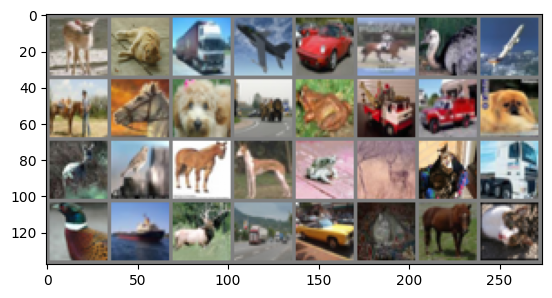

In [3]:
# Define a transform to preprocess the data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Download CIFAR-10 dataset
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Create DataLoader for training and test dataset
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Display some sample images from the training dataset
def imshow(img):
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Iterate through the DataLoader directly to get one batch of images and labels
for images, labels in train_loader:
    break  # Stop after the first batch

# Then proceed to display the images
if images is not None and labels is not None:
    imshow(torchvision.utils.make_grid(images))




In [4]:
# Defining the CNN Model Architecture
class CNN_Model(nn.Module):
    def __init__(self):
        super(CNN_Model, self).__init__()
        # Convolutional layer 1
        self.conv1 = nn.Conv2d(3, 32, 3)  # 3 input channels, 32 output channels, 3x3 kernel
        # Convolutional layer 2
        self.conv2 = nn.Conv2d(32, 64, 3)
        # Convolutional layer 3
        self.conv3 = nn.Conv2d(64, 128, 3)
        # Fully connected layers
        self.fc1 = nn.Linear(128 * 2 * 2, 256)  # 128 channels, 2x2 spatial dimensions after pooling
        self.fc2 = nn.Linear(256, 10)  # 10 output classes

        # Pooling layer
        self.pool = nn.MaxPool2d(2, 2)  # 2x2 pooling kernel, stride of 2
        # Activation function
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))  # Conv1 -> ReLU -> Pool
        x = self.pool(self.relu(self.conv2(x)))  # Conv2 -> ReLU -> Pool
        x = self.pool(self.relu(self.conv3(x)))  # Conv3 -> ReLU -> Pool
        x = x.view(-1, 128 * 2 * 2)  # Flatten the tensor
        x = self.relu(self.fc1(x))  # Fully connected layer 1 -> ReLU
        x = self.fc2(x)  # Fully connected layer 2
        return x

# Initialize the CNN model
model = CNN_Model().to(device)

# Output the model architecture for verification
print(model)


CNN_Model(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
)


In [5]:
# Import the necessary modules for defining loss and optimizer
from torch import optim

# Define the loss function (CrossEntropyLoss for classification)
loss_function = nn.CrossEntropyLoss()

# Define the optimizer (Adam optimizer)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Display the selected loss function and optimizer
print("Loss Function:", loss_function)
print("Optimizer:", optimizer)


Loss Function: CrossEntropyLoss()
Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)


In [6]:
# Training Function
def train_model(model, loader, loss_function, optimizer, device):
    model.train()  # Set the model to training mode
    total_loss = 0.0
    corrects = 0
    for inputs, labels in loader:
        inputs, labels = inputs.to(device), labels.to(device)  # Move data to the device
        optimizer.zero_grad()  # Zero the parameter gradients
        outputs = model(inputs)  # Forward pass
        loss = loss_function(outputs, labels)  # Compute loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update model parameters
        total_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        corrects += torch.sum(preds == labels.data)
    return total_loss / len(loader.dataset), corrects.double() / len(loader.dataset)

# Validation Function
def validate_model(model, loader, loss_function, device):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0.0
    corrects = 0
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
            total_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            corrects += torch.sum(preds == labels.data)
    return total_loss / len(loader.dataset), corrects.double() / len(loader.dataset)


In [7]:
# Initialize variables to store training and validation metrics
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

# Training and Validation Cycles
for epoch in range(num_epochs):
    # Training
    train_loss, train_accuracy = train_model(model, train_loader, loss_function, optimizer, device)
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validation
    val_loss, val_accuracy = validate_model(model, test_loader, loss_function, device)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f'Epoch {epoch+1}/{num_epochs}')
    print(f'Training Loss: {train_loss:.4f} | Training Accuracy: {train_accuracy:.4f}')
    print(f'Validation Loss: {val_loss:.4f} | Validation Accuracy: {val_accuracy:.4f}')

# Save the trained model
torch.save(model.state_dict(), 'cnn_model.pth')


Epoch 1/10
Training Loss: 1.4317 | Training Accuracy: 0.4773
Validation Loss: 1.1776 | Validation Accuracy: 0.5811
Epoch 2/10
Training Loss: 1.0419 | Training Accuracy: 0.6302
Validation Loss: 0.9760 | Validation Accuracy: 0.6574
Epoch 3/10
Training Loss: 0.8759 | Training Accuracy: 0.6920
Validation Loss: 0.8823 | Validation Accuracy: 0.6952
Epoch 4/10
Training Loss: 0.7536 | Training Accuracy: 0.7360
Validation Loss: 0.8680 | Validation Accuracy: 0.7040
Epoch 5/10
Training Loss: 0.6666 | Training Accuracy: 0.7665
Validation Loss: 0.8175 | Validation Accuracy: 0.7217
Epoch 6/10
Training Loss: 0.5916 | Training Accuracy: 0.7909
Validation Loss: 0.8304 | Validation Accuracy: 0.7243
Epoch 7/10
Training Loss: 0.5287 | Training Accuracy: 0.8138
Validation Loss: 0.8250 | Validation Accuracy: 0.7384
Epoch 8/10
Training Loss: 0.4669 | Training Accuracy: 0.8345
Validation Loss: 0.8591 | Validation Accuracy: 0.7308
Epoch 9/10
Training Loss: 0.4141 | Training Accuracy: 0.8523
Validation Loss: 0.

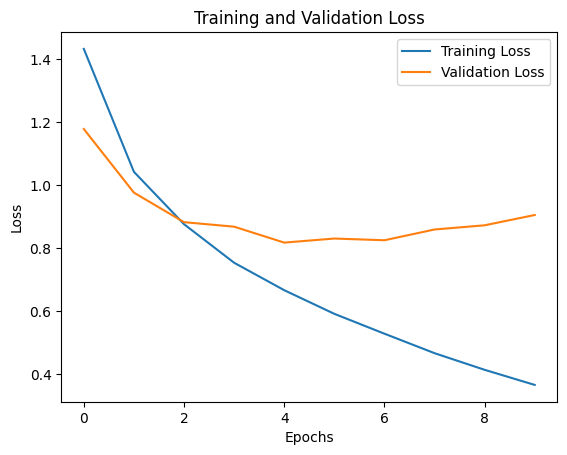

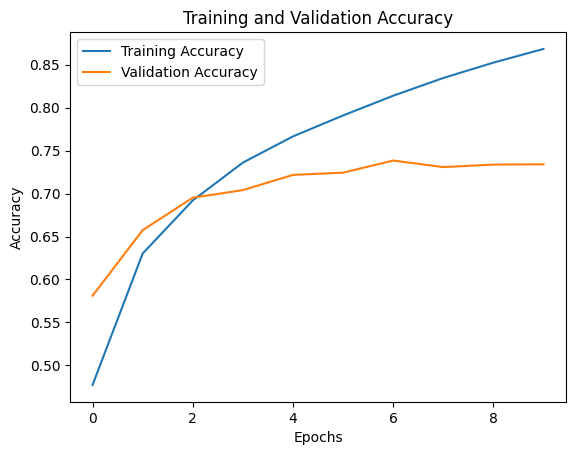

In [8]:
# Function to plot training and validation metrics
def plot_metrics(train_metrics, val_metrics, metric_name):
    # Convert metrics to CPU if they are on GPU
    train_metrics = [metric.cpu().numpy() if isinstance(metric, torch.Tensor) else metric for metric in train_metrics]
    val_metrics = [metric.cpu().numpy() if isinstance(metric, torch.Tensor) else metric for metric in val_metrics]

    plt.plot(train_metrics, label=f'Training {metric_name}')
    plt.plot(val_metrics, label=f'Validation {metric_name}')
    plt.xlabel('Epochs')
    plt.ylabel(metric_name)
    plt.title(f'Training and Validation {metric_name}')
    plt.legend()
    plt.show()

# Plot the training and validation loss
plot_metrics(train_losses, val_losses, 'Loss')

# Plot the training and validation accuracy
plot_metrics(train_accuracies, val_accuracies, 'Accuracy')


In [9]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Function to generate predictions
def get_predictions(model, loader):
    all_preds = []
    all_labels = []
    model.eval()
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return all_preds, all_labels

# Get predictions and true labels
predictions, true_labels = get_predictions(model, test_loader)

# Generate a Classification Report
print("Classification Report:")
print(classification_report(true_labels, predictions, target_names=class_names))

Classification Report:
              precision    recall  f1-score   support

       plane       0.73      0.79      0.76      1000
         car       0.84      0.88      0.86      1000
        bird       0.63      0.66      0.64      1000
         cat       0.62      0.49      0.55      1000
        deer       0.68      0.69      0.69      1000
         dog       0.65      0.63      0.64      1000
        frog       0.74      0.85      0.79      1000
       horse       0.78      0.74      0.76      1000
        ship       0.83      0.84      0.84      1000
       truck       0.84      0.76      0.80      1000

    accuracy                           0.73     10000
   macro avg       0.73      0.73      0.73     10000
weighted avg       0.73      0.73      0.73     10000



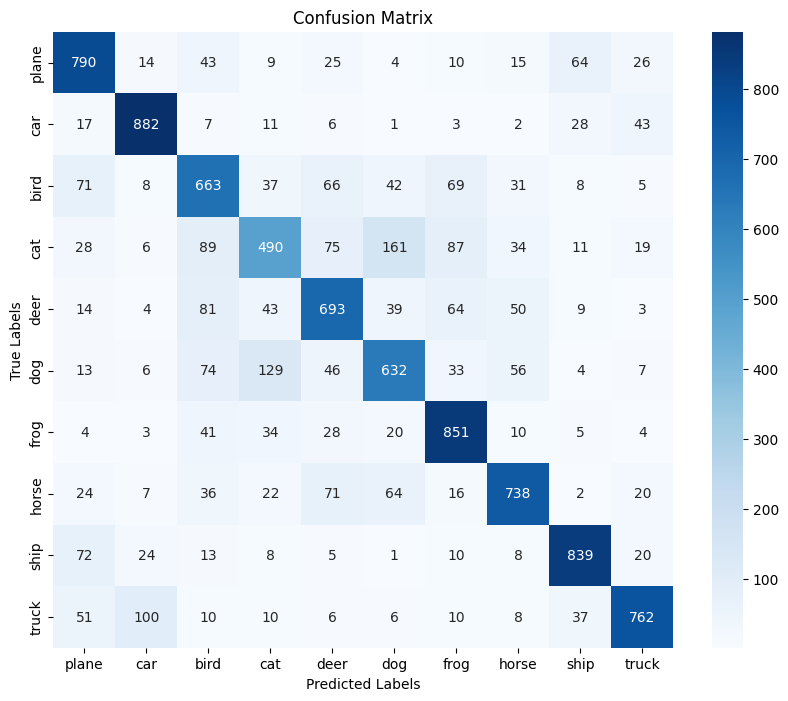

In [10]:
# Generate a confusion matrix
conf_matrix = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [11]:
from torchvision import transforms

# Define a transform with data augmentation
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Update the training DataLoader
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)


Files already downloaded and verified


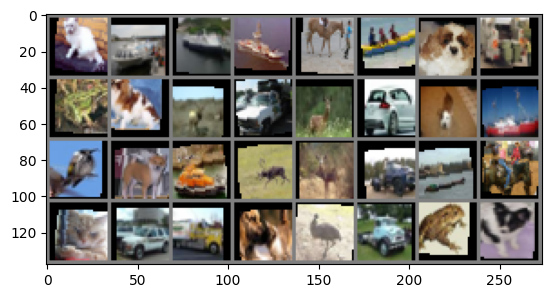

In [12]:
# Function to un-normalize and display an image
def imshow(img):
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get a batch of training data
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Show images
imshow(torchvision.utils.make_grid(images))


In [13]:
# Optimized CNN Model with Dropout Layers
class Optimized_CNN_Model_With_Dropout(nn.Module):
    def __init__(self):
        super(Optimized_CNN_Model_With_Dropout, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 32, 3)
        self.bn1 = nn.BatchNorm2d(32)  # BatchNorm layer
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.bn2 = nn.BatchNorm2d(64)  # BatchNorm layer
        self.conv3 = nn.Conv2d(64, 128, 3)
        self.bn3 = nn.BatchNorm2d(128)  # BatchNorm layer
        self.conv4 = nn.Conv2d(128, 256, 1)  # Additional layer
        self.bn4 = nn.BatchNorm2d(256)  # BatchNorm layer

        # Fully connected layers
        self.fc1 = nn.Linear(256, 512)
        self.dropout = nn.Dropout(0.5)  # Dropout layer
        self.fc2 = nn.Linear(512, 10)

        # Pooling and activation
        self.pool = nn.MaxPool2d(2, 2)
        self.activation = nn.LeakyReLU(0.1)  # Using LeakyReLU

    def forward(self, x):
        x = self.pool(self.activation(self.bn1(self.conv1(x))))
        x = self.pool(self.activation(self.bn2(self.conv2(x))))
        x = self.pool(self.activation(self.bn3(self.conv3(x))))
        x = self.pool(self.activation(self.bn4(self.conv4(x))))  # Additional layer
        x = x.view(x.size(0), -1)
        x = self.activation(self.fc1(x))
        x = self.dropout(x)  # Dropout layer
        x = self.fc2(x)
        return x
# Initialize the optimized CNN model with dropout
optimized_model = Optimized_CNN_Model_With_Dropout().to(device)


In [14]:
# Define the loss function and optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(optimized_model.parameters(), lr=learning_rate)


In [16]:
# Initialize lists to store losses and accuracies
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Training and validation
for epoch in range(num_epochs):
    train_loss, train_accuracy = train_model(optimized_model, train_loader, loss_function, optimizer, device)
    val_loss, val_accuracy = validate_model(optimized_model, test_loader, loss_function, device)

    # Append losses and accuracies for plotting later
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)

    print(f'Epoch {epoch+1}/{num_epochs}')
    print(f'Training Loss: {train_loss:.4f} | Training Accuracy: {train_accuracy:.4f}')
    print(f'Validation Loss: {val_loss:.4f} | Validation Accuracy: {val_accuracy:.4f}')


Epoch 1/10
Training Loss: 1.1249 | Training Accuracy: 0.6017
Validation Loss: 0.9474 | Validation Accuracy: 0.6672
Epoch 2/10
Training Loss: 1.0348 | Training Accuracy: 0.6377
Validation Loss: 0.8984 | Validation Accuracy: 0.6909
Epoch 3/10
Training Loss: 0.9690 | Training Accuracy: 0.6618
Validation Loss: 0.8158 | Validation Accuracy: 0.7164
Epoch 4/10
Training Loss: 0.9208 | Training Accuracy: 0.6816
Validation Loss: 0.7706 | Validation Accuracy: 0.7290
Epoch 5/10
Training Loss: 0.8820 | Training Accuracy: 0.6925
Validation Loss: 0.7371 | Validation Accuracy: 0.7449
Epoch 6/10
Training Loss: 0.8494 | Training Accuracy: 0.7030
Validation Loss: 0.7430 | Validation Accuracy: 0.7459
Epoch 7/10
Training Loss: 0.8307 | Training Accuracy: 0.7115
Validation Loss: 0.7105 | Validation Accuracy: 0.7497
Epoch 8/10
Training Loss: 0.8042 | Training Accuracy: 0.7217
Validation Loss: 0.6699 | Validation Accuracy: 0.7709
Epoch 9/10
Training Loss: 0.7835 | Training Accuracy: 0.7271
Validation Loss: 0.

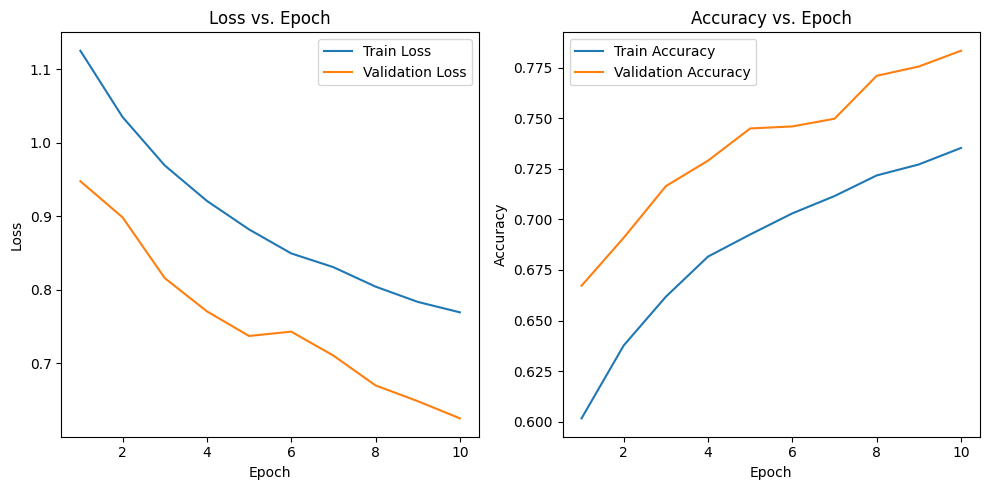

In [17]:
# Plotting training and validation losses
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs. Epoch')
plt.legend()

# Convert tensors to CPU and then to NumPy arrays
train_accuracies_cpu = [item.cpu().numpy() for item in train_accuracies]
val_accuracies_cpu = [item.cpu().numpy() for item in val_accuracies]

# Plotting training and validation accuracies
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), train_accuracies_cpu, label='Train Accuracy')
plt.plot(range(1, num_epochs+1), val_accuracies_cpu, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Epoch')
plt.legend()

plt.tight_layout()
plt.show()


In [20]:
# Initialize lists to store true and predicted labels
y_true = []
y_pred = []

# Make predictions using the optimized model
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = optimized_model(inputs)
        _, preds = torch.max(outputs, 1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# Generate and print the classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))




Classification Report:
              precision    recall  f1-score   support

       plane       0.79      0.81      0.80      1000
         car       0.91      0.89      0.90      1000
        bird       0.72      0.67      0.69      1000
         cat       0.64      0.62      0.63      1000
        deer       0.73      0.80      0.77      1000
         dog       0.70      0.71      0.71      1000
        frog       0.80      0.86      0.83      1000
       horse       0.89      0.73      0.80      1000
        ship       0.82      0.89      0.85      1000
       truck       0.84      0.85      0.85      1000

    accuracy                           0.78     10000
   macro avg       0.78      0.78      0.78     10000
weighted avg       0.78      0.78      0.78     10000



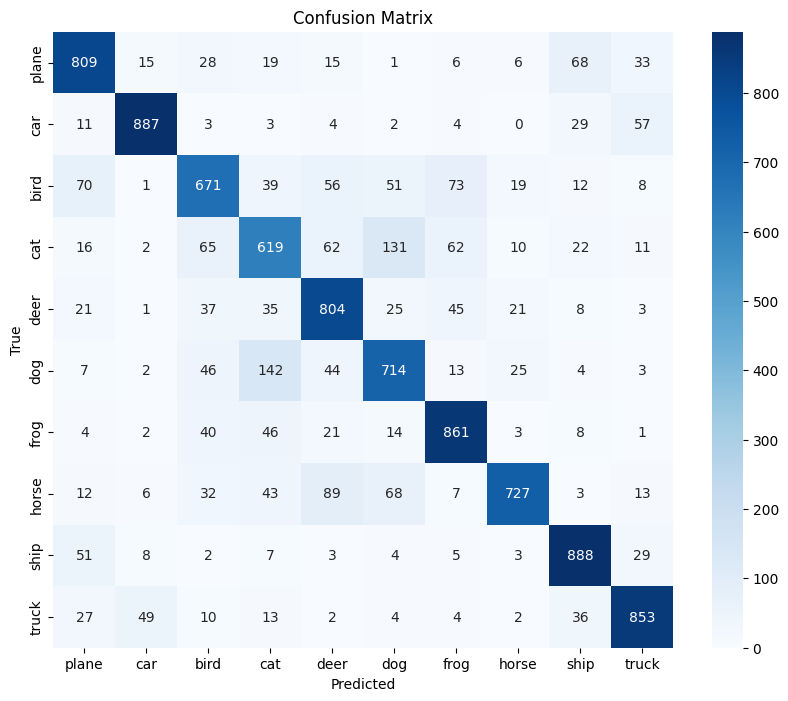

In [19]:
# Generate and visualize the confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()